In [157]:
#Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import sys
from time import time
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Importing the Keras libraries and packages for LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import TensorBoard

### Reading Dataset
The dataset is read from the training file, full data is stored in `train` and TV series data is filtered and stored in `train_TV`

In [2]:
#Importing dataset
train = pd.read_csv('./data/train_1.csv').fillna(0)
page = train['Page']
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [4]:
train_TV = train[train['Page'].str.contains('TV_series')]
train_TV.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
8457,A_Series_of_Unfortunate_Events_(TV_series)_en....,0.0,0.0,0.0,0.0,5.0,30.0,5.0,3.0,2.0,...,1853.0,2023.0,1767.0,1525.0,1959.0,2279.0,2564.0,2192.0,1959.0,1614.0
8515,American_Crime_(TV_series)_en.wikipedia.org_de...,876.0,663.0,671.0,660.0,727.0,947.0,739.0,749.0,736.0,...,1170.0,953.0,836.0,728.0,1078.0,1258.0,1253.0,1352.0,1178.0,1082.0
8538,Animal_Kingdom_(TV_series)_en.wikipedia.org_de...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,706.0,599.0,607.0,458.0,741.0,1108.0,2496.0,2832.0,1141.0,871.0
8567,Arrow_(TV_series)_en.wikipedia.org_desktop_all...,8233.0,7920.0,7049.0,6736.0,8129.0,8946.0,8638.0,8529.0,8812.0,...,6482.0,5263.0,4435.0,4269.0,5299.0,6665.0,6684.0,6538.0,5870.0,4593.0
8621,Bates_Motel_(TV_series)_en.wikipedia.org_deskt...,2025.0,1953.0,2088.0,1969.0,2079.0,2632.0,2266.0,2368.0,2171.0,...,1496.0,1199.0,1113.0,1022.0,1335.0,1757.0,1690.0,1609.0,1568.0,1338.0


### Extracting the features
The features are extracted from the Page name

In [3]:
def get_source(page):
    res = re.search('_[a-z]+\.[a-z]+\.[a-z]+_[a-z\-]+_[a-z]+',page)
    if res:
        return res.group().split('_')[1]
    return 'na'

def get_access(page):
    res = re.search('_[a-z]+\.[a-z]+\.[a-z]+_[a-z\-]+_[a-z]+',page)
    if res:
        return res.group().split('_')[2]
    return 'na'

def get_agent(page):
    res = re.search('_[a-z]+\.[a-z]+\.[a-z]+_[a-z\-]+_[a-z]+',page)
    if res:
        return res.group().split('_')[3]
    return 'na'

Separate code for full dataset and tv series dataset

In [ ]:
source = train.Page.map(get_source)
access = train.Page.map(get_access)
agent = train.Page.map(get_agent)

le = preprocessing.LabelEncoder()
source = le.fit_transform(source)
access = le.fit_transform(access)
agent = le.fit_transform(agent)

In [5]:
source_TV = train_TV.Page.map(get_source)
access_TV = train_TV.Page.map(get_access)
agent_TV = train_TV.Page.map(get_agent)

le = preprocessing.LabelEncoder()
source_TV = le.fit_transform(source_TV)
access_TV = le.fit_transform(access_TV)
agent_TV = le.fit_transform(agent_TV)

Dropping the Page column from the dataset

In [6]:
train = train.drop('Page',axis=1)
train_TV = train_TV.drop('Page', axis=1)

### One hot encoding

One-hot encoding the categories, of course separately for TV series and full dataset

In [7]:
source = np.reshape(source, (-1,1))
access = np.reshape(access, (-1,1))
agent = np.reshape(agent, (-1,1))

enc = preprocessing.OneHotEncoder()

source = enc.fit_transform(source)
access = enc.fit_transform(access)
agent = enc.fit_transform(agent)

In [8]:
source_TV = np.reshape(source_TV, (-1,1))
access_TV = np.reshape(access_TV, (-1,1))
agent_TV = np.reshape(agent_TV, (-1,1))

enc = preprocessing.OneHotEncoder()

source_TV = enc.fit_transform(source_TV)
access_TV = enc.fit_transform(access_TV)
agent_TV = enc.fit_transform(agent_TV)

Making sure that we're on right track

In [9]:
print source.shape, train.shape, source_TV.shape, train_TV.shape

(145063, 9) (145063, 550) (538, 1) (538, 550)


Aggregating all the data (one-hot encodings and real-values) into one monolithic data structure.

In [10]:
rows = []

## Memory issues if we select the whole training data
## Please refer to the the attached python code to see the implementation using generator
# for article in range(len(train)):
for article in range(5000):
    row = train.iloc[article,:].values
    row_len = len(row)
    row = np.reshape(row,(1,row_len))
    sourceCol = np.rot90(np.repeat(source[article,:].toarray(), row_len, axis=0),1,(0,1))
    accessCol = np.rot90(np.repeat(access[article,:].toarray(), row_len, axis=0),1,(0,1))
    agentCol = np.rot90(np.repeat(agent[article,:].toarray(), row_len, axis=0),1,(0,1))
    row = np.append(row, sourceCol, axis=0)
    row = np.append(row, accessCol, axis=0)
    row = np.append(row, agentCol, axis=0)
    rows.append(row)

rows = np.array(rows)    
print rows.shape, sys.getsizeof(rows)/(1024*1024)

(5000, 15, 550) 314


In [11]:
rows_TV = []

for article in range(len(train_TV)):
    row = train_TV.iloc[article,:].values
    row_len = len(row)
    row = np.reshape(row,(1,row_len))
    sourceCol = np.rot90(np.repeat(source_TV[article,:].toarray(), row_len, axis=0),1,(0,1))
    accessCol = np.rot90(np.repeat(access_TV[article,:].toarray(), row_len, axis=0),1,(0,1))
    agentCol = np.rot90(np.repeat(agent_TV[article,:].toarray(), row_len, axis=0),1,(0,1))
    row = np.append(row, sourceCol, axis=0)
    row = np.append(row, accessCol, axis=0)
    row = np.append(row, agentCol, axis=0)
    rows_TV.append(row)

rows_TV = np.array(rows_TV)    
print rows.shape, sys.getsizeof(rows_TV)/(1024*1024)

(5000, 15, 550) 15


### Converting to time-series data
The time series data with 7 sequence length. We can try out different `seq_length` by changing this variable

In [12]:
seq_length = 7

X = []
y = []

## Refer to above comment - This is a sample -Check generator code in python files attached
# for article in range(len(train)):
for article in range(5000):
    for i in range(0, len(rows[article,0]) - seq_length, 1):
        ts_data = rows[article, :, i: i + seq_length]
        ts_data = np.rot90(ts_data, 3, (0,1))
        ts_output = rows[article, 0, i + seq_length]
        X.append(ts_data)
        y.append(ts_output)

    
X = np.array(X)
print X.shape, len(y), sys.getsizeof(X)/(1024*1024)



(2715000, 7, 15) 2715000 2174


In [13]:
seq_length = 7

X_TV = []
y_TV = []

for article in range(len(train_TV)):
    for i in range(0, len(rows[article,0]) - seq_length, 1):
        ts_data = rows[article, :, i: i + seq_length]
        ts_data = np.rot90(ts_data, 3, (0,1))
        ts_output = rows[article, 0, i + seq_length]
        X_TV.append(ts_data)
        y_TV.append(ts_output)

    
X_TV = np.array(X_TV)
print X_TV.shape, len(y_TV), sys.getsizeof(X_TV)/(1024*1024)


(292134, 7, 15) 292134 234


### Test Train Split
Using the `train_test_split` function to split the data into training and testing datasets. For both the datasets


In [14]:
# Splitting the dataset into the Training set and Test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True)

y_train = np.reshape(y_train,(-1,1))
y_test = np.reshape(y_test, (-1,1))

print X_train.shape

(2172000, 7, 15)


In [16]:
# Splitting the dataset into the Training set and Test set
X_TV_train, X_TV_test, y_TV_train, y_TV_test = train_test_split(X_TV, y_TV, test_size = 0.2, shuffle=False)

y_TV_train = np.reshape(y_TV_train,(-1,1))
y_TV_test = np.reshape(y_TV_test, (-1,1))

print X_TV_train.shape

(233707, 7, 15)


### Model and Training
The LSTM model is used for this dataset. An LSTM layer is followed by a Fully Connected layer. MAPE is used as a loss metric and Adam optimizer is used for training.

In [13]:
# Initialising the RNN
regressor = Sequential()

# Adding the input layerand the LSTM layer
regressor.add(LSTM(units = 32, activation = 'relu', input_shape = (X_train.shape[1], X_train.shape[2])))


# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 32, epochs = 10, verbose = 1, callbacks=[tensorboard])

Using TensorFlow backend.


Epoch 1/10
2172000/2172000 [==============================] - 448s - loss: 487649.0102   
Epoch 2/10
2172000/2172000 [==============================] - 446s - loss: 398273.5806   
Epoch 3/10
2172000/2172000 [==============================] - 450s - loss: 393180.8019   
Epoch 4/10
2172000/2172000 [==============================] - 451s - loss: 436330.8600   
Epoch 5/10
2172000/2172000 [==============================] - 417s - loss: 342856.1882   
Epoch 6/10
2172000/2172000 [==============================] - 391s - loss: 311054.3035   
Epoch 7/10
2172000/2172000 [==============================] - 391s - loss: 419971.7033   
Epoch 8/10
2172000/2172000 [==============================] - 392s - loss: 404364.0420   
Epoch 9/10
2172000/2172000 [==============================] - 393s - loss: 417417.8668   
Epoch 10/10
2172000/2172000 [==============================] - 394s - loss: 404861.8402   


In [22]:
inputs = X_test

# Getting the predicted Web View
y_pred = regressor.predict(inputs)

print y_train.shape, len(y_test)


(2172000, 1) 543000


In [173]:
# Initialising the RNN
regressor_TV = Sequential()

# Adding the input layerand the LSTM layer
regressor_TV.add(LSTM(units = 32, activation = 'relu', input_shape = (X_train.shape[1], X_train.shape[2])))


# Adding the output layer
regressor_TV.add(Dense(units = 1))

tensorboard = TensorBoard(log_dir="logs_TV/{}".format(time()))

# Compiling the RNN
regressor_TV.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
history = regressor_TV.fit(X_TV_train, y_TV_train, validation_split=0.33, batch_size = 32, epochs = 10, verbose = 1, callbacks=[tensorboard])


Train on 156583 samples, validate on 77124 samples
Epoch 1/10
156583/156583 [==============================] - 40s - loss: 65363.1172 - val_loss: 200999.9859
Epoch 2/10
156583/156583 [==============================] - 39s - loss: 59184.7200 - val_loss: 168095.2604
Epoch 3/10
156583/156583 [==============================] - 39s - loss: 41479.6504 - val_loss: 112756.8943
Epoch 4/10
156583/156583 [==============================] - 41s - loss: 46879.2775 - val_loss: 126822.4966
Epoch 5/10
156583/156583 [==============================] - 40s - loss: 41342.3985 - val_loss: 112557.5475
Epoch 6/10
156583/156583 [==============================] - 40s - loss: 59198.0753 - val_loss: 124827.4408
Epoch 7/10
156583/156583 [==============================] - 40s - loss: 56224.3290 - val_loss: 116126.7241
Epoch 8/10
156583/156583 [==============================] - 40s - loss: 56440.1588 - val_loss: 135576.0962
Epoch 9/10
156583/156583 [==============================] - 40s - loss: 64890.1709 - val_loss

KeyError: 'acc'

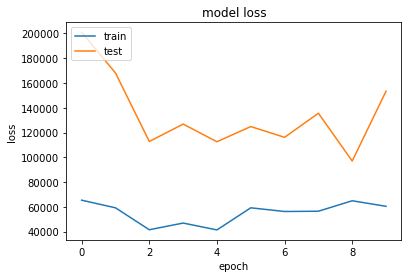

In [174]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Evaluation
We evaluate the model visually as well as numerically. 

#### Numerical Evaluation
We evaluate the loss on testing data and training data

In [ ]:
loss_train = regressor.evaluate(X_train, y_train,batch_size=32,verbose=1)
loss_test = regressor.evaluate(X_test, y_test,batch_size=32,verbose=1)

print '\nTraining Loss: ', loss_train
print 'Testing Loss: ', loss_test

In [138]:
loss_train = regressor_TV.evaluate(X_TV_train, y_TV_train,batch_size=32,verbose=1)
loss_test = regressor_TV.evaluate(X_TV_test, y_TV_test,batch_size=32,verbose=1)

print '\nTraining Loss: ', loss_train
print 'Testing Loss: ', loss_test

58112/58427 [============================>.] - ETA: 0s
Training Loss:  58048.9731326
Testing Loss:  731.644374356


#### Visual
We plot the real data against the predicted data for each

In [128]:
inputs = X_test

# Getting the predicted Web View
y_pred = regressor.predict(inputs)

print X_test.shape, len(y_test)

(58427, 7, 15) 58427


In [139]:
inputs = X_TV_test

# Getting the predicted Web View
y_TV_pred = regressor_TV.predict(inputs)

print X_TV_test.shape, len(y_TV_test)

(58427, 7, 15) 58427


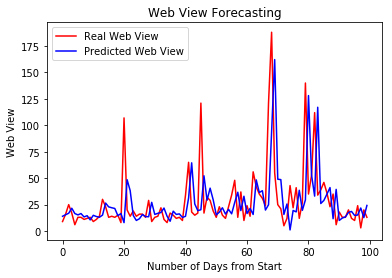

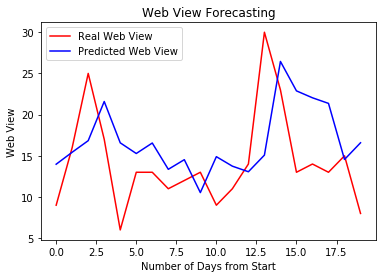

In [129]:
#Visualising Result
plt.figure
plt.plot(y_test[1200:1300], color = 'red', label = 'Real Web View')
plt.plot(y_pred[1200:1300], color = 'blue', label = 'Predicted Web View')
plt.title('Web View Forecasting')
plt.xlabel('Number of Days from Start')
plt.ylabel('Web View')
plt.legend()
plt.show()


plt.figure
plt.plot(y_test[1200:1220], color = 'red', label = 'Real Web View')
plt.plot(y_pred[1200:1220], color = 'blue', label = 'Predicted Web View')
plt.title('Web View Forecasting')
plt.xlabel('Number of Days from Start')
plt.ylabel('Web View')
plt.legend()
plt.show()

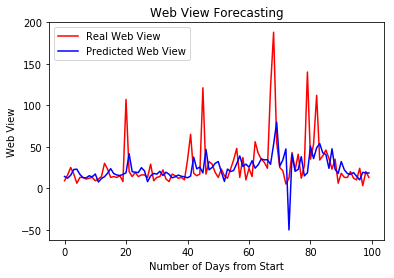

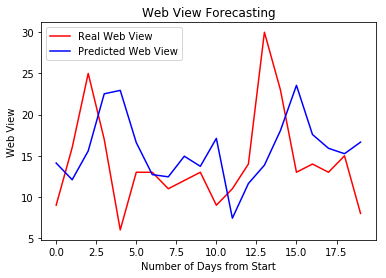

In [140]:
#Visualising Result
plt.figure
plt.plot(y_TV_test[1200:1300], color = 'red', label = 'Real Web View')
plt.plot(y_TV_pred[1200:1300], color = 'blue', label = 'Predicted Web View')
plt.title('Web View Forecasting')
plt.xlabel('Number of Days from Start')
plt.ylabel('Web View')
plt.legend()
plt.show()


plt.figure
plt.plot(y_TV_test[1200:1220], color = 'red', label = 'Real Web View')
plt.plot(y_TV_pred[1200:1220], color = 'blue', label = 'Predicted Web View')
plt.title('Web View Forecasting')
plt.xlabel('Number of Days from Start')
plt.ylabel('Web View')
plt.legend()
plt.show()

### Save the model

In [91]:
regressor.save('model_500a_7ts_32u_lstm_adam_32b_10e.h5')

In [141]:
regressor_TV.save('model_tv_7ts_32u_lstm_adam_32b_20e.h5')

### Generative Model
The code below can be used to create a generative model. Given a random seed, the same model can be used to generate the Web Traffic prediction for next 100 days.

In [152]:
start = np.random.randint(0, len(X_TV_test)-1)
pattern = X_TV_test[start,:,:]
y_TV_gen = []
gen_len = 100

for i in range(gen_len):
    x = np.reshape(pattern, (1, 7, 15))
    prediction = regressor_TV.predict(x)
    temp_x = x[:,:,14]
    temp_x = [[temp_x[0][i+1] for i in range(len(temp_x[0])-1)]]
    temp_x[0].append(prediction[0][0])
    x[:,:,14] = temp_x
    pattern = np.array(x)
    y_TV_gen.append(prediction[0])


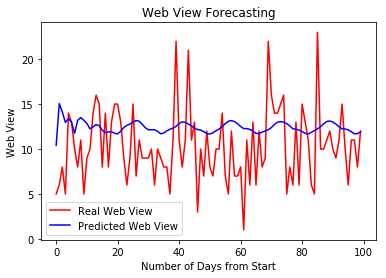

In [153]:
plt.figure
plt.plot(y_TV_test[start:start+gen_len], color = 'red', label = 'Real Web View')
plt.plot(y_TV_gen, color = 'blue', label = 'Predicted Web View')
plt.title('Web View Forecasting')
plt.xlabel('Number of Days from Start')
plt.ylabel('Web View')
plt.legend()
plt.show()

#### Rows giving good results
11233 - 
13086 - The walking dead